#**Upravljanje multi-agentnim sustavima**

(verzija od 19.svi 2023.)

* koristimo Schurovu dekompoziciju za ortogonalni komplement od jezgre od $L$
* Plotamo vrijednost $||F_i(s)||$
* Koristi se samo sustav dimenzije $n$ (dimenzija Laplaceove matrice grafa) 
* Uvodimo 4 različite klase grafova na kojima ćemo testirati vrijedsnot $||F_i(s)||$


##**Raspisano**
Računamo vrijednost funkcije $F_i(s)$:
\begin{align*}
         F_i(s)  & = \frac{1}{is\alpha + \gamma}VV^T(L-\mu(s)I)^{-1}e_i \\
         & = \left[\: L = ZTZ^T \: \right]\\
         & = \frac{1}{is\alpha + \gamma}VV^TZ(T-\mu(s)I)^{-1}Z^*e_i  \\
         & = \left[ \: VV^TZ = VV^T[\:W \:\: V \:] = V \left[\:0 \: \: I\: \right]  \right] \\
         & = \frac{1}{is\alpha + \gamma}\left[\:0_{n×k} \:\: V \:\right](T-\mu(s)I)^{-1}Z^*e_i\\
         & = \left[\: Z^*e_i = [Z_0 Z_1]^T, \: \: Z_0 \in M_{k,1}, Z_1 \in M_{n-k,1}\: \right]\\
         & = \frac{1}{is\alpha + \gamma} V (T_{22} - \mu(s)I)^{-1} Z_1
\end{align*}

Za $L$ koristimo Schurovu dekompoziciju za $L= ZTZ^T$, $Z= [\: W\:\: V\:],$ $ \: W \in M_{n,k},$ $ \: V \in M_{n,n-k},$ gdje su V stupci od $Z$ koji pripadaju ne-nul elementima i dolazimo do oblika za $\Phi$ (jer vrijedi $L = L V V^T$):

$$\Phi(s) = \left(is \alpha + \gamma \right)\left(\frac{is\beta -s^2}{is \alpha + \gamma}I +L\right) = \\ =  (is \alpha + \gamma)\left(L - \mu(s)I\right),$$
gdje je $\mu(s) =\frac{is\beta -s^2}{is \alpha + \gamma} $.

Za vrijednost u $0$:
$$F_i(0) = \frac{1}{\gamma}V(V^TLV)^{-1}V^Te_i,$$ iskoristi se Schur za L i def za V pa se dobije
$$F_i(0) = \frac{1}{\gamma}VT_{22}^{-1}V^Te_i, $$
gdje je $$ T = 
\begin{bmatrix}
  T_{11} & T_{12}\\
  0 & T_{22}
  \end{bmatrix}.
$$ Pritom blok matrica $T_{11} \in M_{k,k}$ na dijagonali ima $0$, a $T_{22} \in M_{n-k,n-k}$ ima ne-nul svojstvene vrijednosti.




In [1]:
import networkx as nx

import numpy as np
from scipy.sparse import csgraph
import scipy.signal as signal
import scipy.linalg as la
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import math
import time

###**`Laplace_inDegree`**
*   za graf G vraća Laplacian u željenoj formi.

In [2]:
def _Laplace_inDegree(G):
  A = nx.adjacency_matrix(G)
  A = np.transpose(A)
  D = np.diag(A @ np.ones(np.size(A,1)).transpose())
  return D-A;

##**`mu_`**
* input: $\alpha, \beta, \gamma$
*output: funkcija ovisna o parametru $s$:  $$\mu(s)=\frac{is\beta -s^2}{is \alpha + \gamma} $$

In [3]:
def mu_(alpha, beta, gamma):
    def mu(s):
        return (s*s-1j*s*beta)/(gamma + 1j*alpha*s);
    return mu;

###**`get_Fi`**
*   za graf $G$, parametre $\alpha, \beta, \gamma$, računa $Schurovu$ dekompoziciju inDegree Laplaceove matrice grafa, vraća ugnježdenu funkciju koja prima komponentu $i$ i dimenziju jezgre Laplaceove matrice grafa.

* pritom se kod računanja koristi `scipy.linalg.solve_triangular` koja poziva `LAPACK` rutinu za trokutasti linearni sustav jedndadžbi

Primjer poziva:

```
sys_f, Kernel_dim, ndim = get_Fi(G,alpha,beta,gamma)
Fi = sys_f(i)
print(Fi(5))
```




##### Testni primjer:
```python
L = _Laplace_inDegree(G)
ndim = np.shape(L)[0];
T,Z,dim_Ker_L = la.schur(L, sort = lambda x: abs(x)<1e-12)
print(np.shape(T),dim_Ker_L, np.shape(Z[dim_Ker_L:,3]))
print(np.max(np.diag(T)))

sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(G)
Fi = sys_f(2,1,1,1)
print(Fi(5))
```

In [ ]:
L = _Laplace_inDegree(G)
ndim = np.shape(L)[0];
T,Z,dim_Ker_L = la.schur(L, sort = lambda x: abs(x)<1e-12)
print(np.shape(T),dim_Ker_L, np.shape(Z[dim_Ker_L:,3]))
print(np.max(np.diag(T)))

sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(G)
Fi = sys_f(2,1,1,1)
print(Fi(5))

In [4]:
def get_Fi_norm(G):
    L = _Laplace_inDegree(G)
    ndim = np.shape(L)[0];
    T,Z,dim_Ker_L = la.schur(L, sort = lambda x: abs(x)<1e-12)
    max_diagonal = np.max(np.abs(np.diag(T)))
    print("- - - - - Računam Schurovu dekompoziciju")
    V = Z[:,dim_Ker_L:]
    EYE = np.diag(np.ones(ndim - dim_Ker_L))
    
    def FF_(i,alpha,beta,gamma):
        alpha_2 = alpha*alpha
        gamma_2 = gamma*gamma
        M = mu_(alpha,beta,gamma)
        VTei = V.T.conj()[:,i-1]
        Z_Tei = Z.T.conj()[dim_Ker_L:,i-1]
        
        def Fi(s):
            if (s == 0):
                #A = T[dim_Ker_L:,dim_Ker_L:] #uzmemo T_22
                x = la.solve_triangular(T[dim_Ker_L:,dim_Ker_L:],VTei)  #solve_triangular poziva
                #LAPACK rutinu za trokutasti sustav
                nrm =la.norm(V @ x /gamma)
                F = nrm
            else:
                x = la.solve_triangular(T[dim_Ker_L:,dim_Ker_L:] - EYE*M(s),Z_Tei)
                F = la.norm(V @ x)/np.sqrt(s*s*alpha_2 + gamma_2)
            return F;
        return Fi;
    return FF_, dim_Ker_L, ndim, max_diagonal;

#**Poziv nekog grafa G:**

[Dokumentacija](https://networkx.org/documentation/stable/reference/generators.html#module-networkx.generators.directed) za generatore grafova.

`gn_graph(n[, kernel, create_using, seed])` - Returns the growing network (GN) digraph with n nodes.

`gnr_graph(n, p[, create_using, seed])` - Returns the growing network with redirection (GNR) digraph with n nodes and redirection probability p.

`gnc_graph(n[, create_using, seed])` - Returns the growing network with copying (GNC) digraph with n nodes.

`random_k_out_graph(n, k, alpha[, ...])` - Returns a random k-out graph with preferential attachment.

`scale_free_graph(n)` - Returns a scale-free directed graph.

In [5]:
import random
def scale_free_directed_graph(n, alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, seed=None):
    G = nx.DiGraph()
    G.add_node(0)

    nodes = list(G.nodes())
    cursor = 0
    random.seed(seed)

    while len(G) < n:
        r = random.random()

        if r < alpha:
            v = cursor
            cursor += 1
            w = random.choice(nodes)

        elif r < alpha + beta:
            v = random.choice(nodes)
            w = random.choice(nodes)

        else:
            v = random.choice(nodes)
            w = cursor
            cursor += 1

        if v != w and not G.has_edge(v, w):
            G.add_edge(v, w)

        nodes = list(G.nodes())

    return G

In [7]:
TTT = generate_graphs(4)
TTT[4][1]
for G in TTT:
    print(type(G[0]))
    print(_Laplace_inDegree(G[0]))

<class 'networkx.classes.digraph.DiGraph'>
[[ 3. -1. -1. -1.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
<class 'networkx.classes.digraph.DiGraph'>
[[ 3. -1. -1. -1.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1. -1.]
 [ 0.  0.  0.  0.]]
<class 'networkx.classes.multidigraph.MultiDiGraph'>
[[ 4. -3.  0. -1.]
 [-3.  5. -1. -1.]
 [ 0.  0.  2. -2.]
 [-1. -1. -3.  5.]]
<class 'networkx.classes.digraph.DiGraph'>
[[ 1.  0. -1.  0.]
 [-1.  2.  0. -1.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
<class 'networkx.classes.digraph.DiGraph'>
[[ 1. -1.  0.  0.]
 [ 0.  2. -1. -1.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
<class 'networkx.classes.digraph.DiGraph'>
[[ 3. -1. -1. -1.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
<class 'networkx.classes.digraph.DiGraph'>
[[ 2. -1. -1.  0.]
 [ 0.  1.  0. -1.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


In [6]:
def generate_graphs(n):
    A = nx.gnr_graph(n, 0.5)
    B = nx.gnc_graph(n)
    C = nx.random_k_out_graph(n, 4, 50.0, self_loops=False, seed=None)    
    D = scale_free_directed_graph(n)
    E = nx.gn_graph(n)
    F = nx.gn_graph(n, kernel=lambda x: x ** 1.5)
    G = nx.gn_graph(n, kernel=lambda x: math.exp(x*1.4))
        
    descriptionA = "gnr_graph(" + str(n) + ", 0.5)"
    descriptionB = "gnc_graph(" + str(n) + ")"
    descriptionC = "random_k_out_graph(" + str(n) + "4, 50.0, self_loops=False, seed=None)"
    descriptionD = "scale_free_directed_graph("+str(n)+")"
    descriptionE = "gn_graph(" + str(n) + ")"
    descriptionF = "gn_graph(" + str(n) + ", kernel=lambda x: x ** 1.5)"
    descriptionG = "gn_graph(" + str(n) + ", kernel=lambda x: math.exp(x*1.4))"
    
    return [(A,descriptionA),(B,descriptionB),(C,descriptionC),(D,descriptionD),(E,descriptionE),(F,descriptionF),(G,descriptionG)]

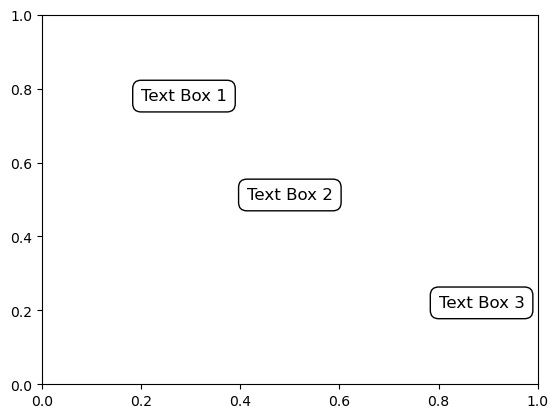

In [8]:
# Create a plot
plt.figure()

# Add text boxes
text_box1 = plt.text(0.2, 0.8, 'Text Box 1', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
text_box2 = plt.text(0.5, 0.5, 'Text Box 2', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
text_box3 = plt.text(0.8, 0.2, 'Text Box 3', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Customize the text boxes
text_box1.set_verticalalignment('top')
text_box2.set_horizontalalignment('center')
text_box3.set_verticalalignment('bottom')

# Show the plot
plt.show()

In [ ]:
G,gamma,s_opt, s_range, vals, arg = CounterExamples_3[0]
print(arg)
#print(np.size(s_range))
#print(len(vals))
sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(G)
Fi = sys_f(0,1,1,gamma)
plt.figure(figsize=(20,10))
plt.plot()
s_opt_index = np.where(s_range == s_opt)[0][0]
s_opt_obj = vals[s_opt_index]
plt.scatter(s_opt, s_opt_obj, color='red', label='s_opt')
ind = s_opt_index+20
plt.plot(s_range[:ind], vals[:ind], label = f"i={i}")

plot_norm_function(G,gamma,s_opt, s_range, vals, arg)

In [ ]:
sys_f, Kernel_dim, ndim, L_sigma = get_Fi(G,alpha,beta,gamma)
Fi = sys_f(i)
print(Fi(5))

    obj_values.append([Fi(s) for s in s_range])
    
x0 = 0.1
left_end = 0
right_end = L_sigma*5
spacing = 0.001
bounds = [(left_end,right_end)]
s_range = np.arange(left_end,right_end, spacing)

- - - - - Računam Schurovu dekompoziciju


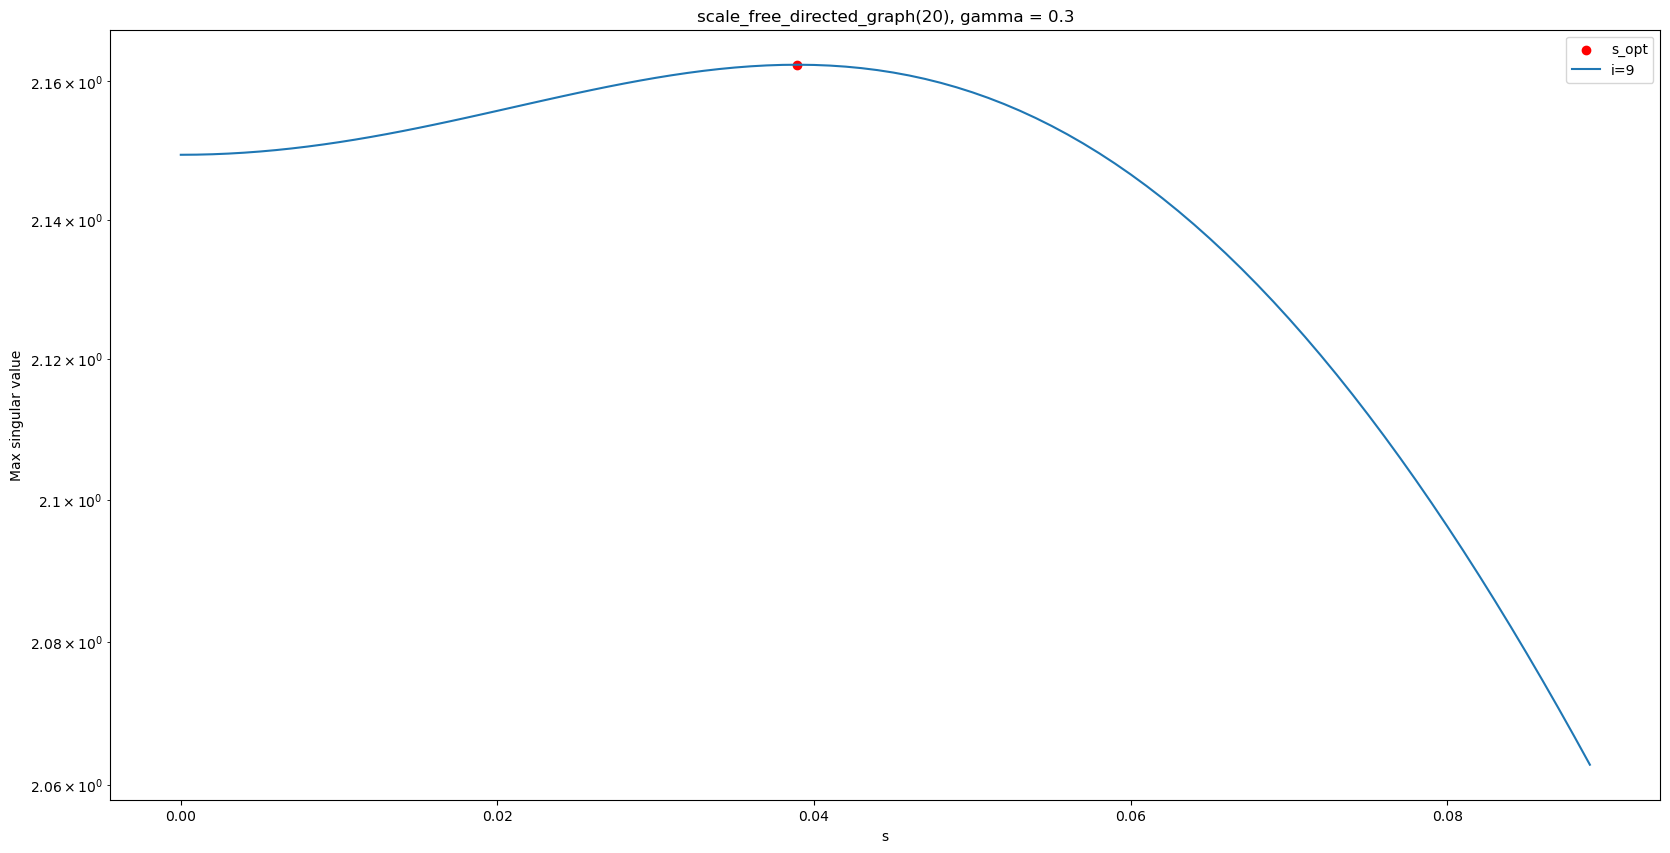

In [58]:
sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(Graf)
Fi = sys_f(indexi[0],alpha,beta,gamma)
x0 = 0.1
left_end = 0
right_end = L_sigma*5
spacing = 0.001
bounds = [(left_end,right_end)]
s_range = np.arange(left_end,right_end, spacing)
plt.figure(figsize=(20,10))
plt.plot()
plt.scatter(optimal_s[0], obj_values[0][args[0]], color='red', label='s_opt')
ind = indexi[0]*10
plt.plot(s_range[:ind],[Fi(s) for s in s_range[:ind]], label = f"i={indexi[0]}")
plt.xlabel('s')
plt.ylabel('Max singular value')
plt.yscale('log')
plt.legend()
titl = opis + ", gamma = "+ str(gamma)
plt.title(titl)
plt.show()

In [73]:
tup = (arg, 7, Graf)
print(tup[0], tup[1], tup[2])

0 7 DiGraph with 20 nodes and 33 edges


In [ ]:
Graf, opis,gamma,indexi,optimal_s, ranges, obj_values, args, poruka, norm_values = GGGG

plot_norm_function(Graf, opis, gamma,indexi[0], optimal_s[0], ranges[0], obj_values[0], args[0])

In [33]:
def plot_norm_function(G, naslov, gamma,i, s_opt, s_range, vals, arg):
    #i =0
    plt.figure(figsize=(20,10))
    #for obj in obj_values:
    print(np.size(s_range))
    print(len(vals))
    plt.plot()
    s_opt_index = np.where(s_range == s_opt)[0][0]
    print(s_opt_index)
    s_opt_obj = vals[s_opt_index]
    plt.scatter(s_opt, s_opt_obj, color='red', label='s_opt')
    ind = s_opt_index+20
    plt.plot(s_range[:ind], vals[:ind], label = f"i={i}")
    i+=1;

    plt.xlabel('s')
    plt.ylabel('Max singular value')
    plt.yscale('log')
    plt.legend()
    plt.title(naslov)
    
    #text_box1 = plt.text(0.2, 0.8, r'$\gamma = {}$'.format(gamma), fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    # Customize the text boxes
    text_box1.set_verticalalignment('top')

    plt.show()
    #print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)

In [13]:
def plot_graph(G, norm_values):
    plt.figure(figsize=(20,15))
    pos = nx.spring_layout(Graph)

    nodes = nx.draw_networkx_nodes(Graph, pos, node_color=norm_values, cmap='coolwarm', node_size=70)
    edgclr = (224/255.0,229/255.0,255/255.0)
    nx.draw_networkx_edges(Graph, pos,edge_color=edgclr)

    #Odaberemo 10 vrhova s najvećom normom
    largest_indices = np.argsort(norm_values)[-10:]
    node_labels = {n: n for n in largest_indices}
    #node_labels = {n:norm_values[n] for n in Graph.nodes()}
    nx.draw_networkx_labels(Graph, pos, labels=node_labels, font_color='black', verticalalignment='bottom', horizontalalignment='left')
    #nx.draw(Graph,pos, node_color = node_colors, cmap = 'coolwarm', node_size=100)# labels = node_labels)

    # Odvojeni colorbar plot
    cbar = plt.colorbar(nodes, label='Norm', orientation='horizontal', shrink=0.5)
    cbar.ax.set_xlabel('Norm Values')
    plt.subplots_adjust(bottom=0.2)  

    plt.title('Graf D sa obojanim vrhovima po vrijednosti Norme')
    plt.savefig('graph.png')  # Save the plot as a PNG file
    plt.show()
    print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
    print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

## Naći max od $H_\infty$: (npr. pomoću Nelder-Mead)

Računanje $max_{\omega \in \mathbb{R}} \overline{\sigma}(\hat{F}(j\omega))$

Računamo normu od:

$F_i(s) = VV^T \Phi(s)^{-1}e_i$

$F_i(0) = \frac{1}{\gamma}V (V^TLV)^{-1}V^Te_i$

$||F_i(s)||^2_\infty = sup_s||F_i(s)||^2_2 = sup_s ||VV^T \Phi(s)^{-1}e_i||^2_2$

Ovdje koristimo funkciju koja vraća normu vektora $F_i(s)$ pa je funkcija cilja u optimizaciju norma tog vektora.

U varijablu L_sigma spremimo najveću svojstvenu vrijednost.

In [68]:
print(len(CounterExamples))
CounterExamples = CounterExamples + CounterExamples_0
print(len(CounterExamples))

0
26


In [79]:
print(len(CounterExamples_0))

55


In [78]:
def obj_fun(s):
    return -Fi(s)

# za svaki tip grafa želimo ga testirati na 1000 slučajno kreiranih grafova
# cilj je za svaki graf provrtiti 10 različitih gamma

#Ukupno ćemo imati 70 000 primjera
# Odaberi broj vrhova:
n = 60
#Odaberi broj generiranja grupe grafova
N = 5
#- sadrži graf G i točku koju vraća Nelder-Mead - NM je zapeo u lokalnom ekstremu
CounterExamples_2 = [] # Nelder-Mead i argmax nisu jednaki - (G,s_opt) 
CounterExamples_3= [] # Nelder-Mead daje isto kao i argmax - a nije u nuli

alpha = 1
beta = 1
start_time = time.time()
# N puta generirat ćemo grupu od 7 grafova
for j in range(N):
    
    start_time_j = time.time()
    print("\n",j+1,"/-ta grupa grafova. Ukupno N = ", N,".")
    
    GRAPHS = generate_graphs(n)
    
    #za svaki graf tražimo gdje se postiže max
    # u G se nalazi tupple: (Graf, opis grafa)
    for G in GRAPHS:
        start_time_Graph = time.time()
        sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(G[0])
        print("Najveća svojstvena vrijednost: ",L_sigma)
        x0 = 0.1
        left_end = 0
        right_end = L_sigma*10
        spacing0 = 0.001
        spacing1 = 0.1
        bounds = [(left_end,right_end)]
        
        # variramo parametar gamma
        for k in range(1,11):
            start_time_gamma = time.time()
            gamma = k/10
            now = time.time()
            
            obj_values = []
            norm_values = []
            optimal_s = []
            norm0_values = []
            ranges = []
            indexi = []
            args = []
            not_in_list = True
            
            for i in range(ndim):
                Fi = sys_f(i,alpha,beta,gamma)
                res = minimize(obj_fun, x0, bounds=bounds, method='Nelder-Mead')
                s_opt = res.x[0]
                norm = -res.fun # spremi vrijednost maximuma
                norm_values.append(norm) # iznosi normi iz Nelder-Meada
                
                if (s_opt == 0.0):
                    s_range = np.arange(left_end,right_end, spacing1)
                else:
                    s_range = np.arange(left_end,s_opt, spacing0)
                    s_range = np.concatenate((s_range, np.arange(s_opt,s_opt*5, spacing0 )))
                    #s_range = np.concatenate((s_range, np.arange(s_opt*5,right_end, spacing1 )))
                
                vals = [Fi(s) for s in s_range]
                maxi = max(vals)
                arg = vals.index(maxi)
                
                #Što sve trebam spremiti?
                #trebam spremiti
                ### Graf za kojeg tvrdnja ne vrijedi
                ### gamma
                ### indeks i na kojem se max of Fi ne postiže u 0
                ### s_opt različite od nula
                ### s_range na kojem se ispituje max
                ### arg u obj_val u kojem se postiže max
                ### norm_values
                ### poruka
                
                if (arg != 0) and not_in_list:
                    not_in_list = False
                    indexi.append(i)
                    ranges.append(s_range)
                    optimal_s.append(s_opt) # spremljena točka s za koju se postiže min
                    #norm0_values.append(la.norm(Fi(0))) # iznosi norme u nuli.
                    obj_values.append(vals) # spremljen graf of Fi duž domene s
                    args.append(arg)
                    poruka = "Nađen kontraprimjer. gamma = " + str(gamma) + \
                             "    (i, s_opt, s_range[arg], arg) = " + str(i) + \
                             "," + str(s_opt) + ", " + str(s_range[arg]) + ", " + str(arg)
                    print("       ",poruka)  
                elif (s_opt != s_range[arg]) and not_in_list:
                    not_in_list = False
                    indexi.append(i)
                    ranges.append(s_range)
                    optimal_s.append(s_opt) # spremljena točka s za koju se postiže min
                    #norm0_values.append(la.norm(Fi(0))) # iznosi norme u nuli.
                    obj_values.append(vals) # spremljen graf of Fi duž domene s
                    args.append(arg)
                    poruka = "Nađen kontraprimjer. Nelder-Mead zapeo u lok. ekstremu. gamma = " + str(gamma) + \
                             "    (i, s_opt, s_range[arg], arg) = " + str(i) + \
                             "," + str(s_opt) + ", " + str(s_range[arg]) + ", " + str(arg)
                    print("       ",poruka)                   
                    
            if not not_in_list:
                CounterExamples_0.append((G[0],G[1],gamma,indexi,optimal_s, ranges, obj_values, args, poruka, norm_values))
            end_time_gamma = time.time()
            print("     Vrijeme za gamma =",gamma,": {:.4f} sec".format(end_time_gamma - start_time_gamma))
                          
        end_time_Graph = time.time()
        print("- - - - - Vrijeme izvršavanja za jedan graf: {:.4f} sec".format(end_time_Graph - start_time_Graph))
    
    end_time_j = time.time()
    print(" Vrijeme izvršavanja ",j,"-te iteracije: {:.4f} sec\n".format(end_time_j - start_time_j))
end_time = time.time()
print("Ukupno vrijeme izvršavanja: {:.4f} sec\n".format(end_time - start_time))


 0 -ta grupa grafova.
- - - - - Računam Schurovu dekompoziciju
Najveća svojstvena vrijednost:  11.0
     Vrijeme za gamma = 0.1 : 2.0282 sec
     Vrijeme za gamma = 0.2 : 2.1399 sec
     Vrijeme za gamma = 0.3 : 2.0724 sec
     Vrijeme za gamma = 0.4 : 2.0780 sec
     Vrijeme za gamma = 0.5 : 1.9530 sec
     Vrijeme za gamma = 0.6 : 2.0330 sec
     Vrijeme za gamma = 0.7 : 1.9962 sec
     Vrijeme za gamma = 0.8 : 2.0859 sec
     Vrijeme za gamma = 0.9 : 2.1518 sec
     Vrijeme za gamma = 1.0 : 1.9979 sec
- - - - - Vrijeme izvršavanja za jedan graf: 20.5529 sec
- - - - - Računam Schurovu dekompoziciju
Najveća svojstvena vrijednost:  59.0
     Vrijeme za gamma = 0.1 : 14.0048 sec
     Vrijeme za gamma = 0.2 : 14.4999 sec
     Vrijeme za gamma = 0.3 : 13.8909 sec
     Vrijeme za gamma = 0.4 : 14.0748 sec
     Vrijeme za gamma = 0.5 : 14.3237 sec
     Vrijeme za gamma = 0.6 : 14.1068 sec
     Vrijeme za gamma = 0.7 : 14.0141 sec
     Vrijeme za gamma = 0.8 : 14.2244 sec
     Vrijeme za ga

In [22]:
# GGGG = (G,gamma,indexi,optimal_s, ranges, obj_values, args, poruka, norm_values)
# G = (Graf,opis)
indexi
GGGG = CounterExamples_0[0]
print(GGGG[2])

[9]


In [105]:

print(len(CounterExamples_0))
print(CounterExamples_0[2][2][0])
Tup,gamma,indexi,optimal_s, ranges, obj_values, args, poruka, norm_values = CounterExamples_0[2]
print(indexi[0])

55
9
9


In [95]:
Graf, opis,gamma,indexi,optimal_s, ranges, obj_values, args, poruka, norm_values = CounterExamples_0[50]
i = 0
filename = f"{opis}_{i+1:02d}.gexf"
nx.write_gexf(Graf, filename)

In [107]:
#Graf, opis,gamma,indexi,optimal_s, ranges, obj_values, args, poruka, norm_values
# (G[0],G[1],gamma,indexi,optimal_s, ranges, obj_values, args, poruka, norm_values))
# GGGG = (G,gamma,indexi,optimal_s, ranges, obj_values, args, poruka, norm_values)
import json

print("Gotov test za n = 60")
print(len(CounterExamples_0))
j = 0;
for i in CounterExamples_0:
    if isinstance(i[0], tuple):
        Tup,gamma,indexi,optimal_s, ranges, obj_values, args, poruka, norm_values = i
        Graf = Tup[0]
        opis = Tup[1]
        filename = f"{j+1:02d}_gamma={gamma}_i={indexi[0]}_{opis}.gexf"
        nx.write_gexf(Graf, filename)
        #Tup1 = (opis,gamma,indexi,optimal_s, ranges, obj_values, args, poruka, norm_values)
        #filename = f"{opis}_{j+1:02d}.json"
        #with open(filename, "w") as file:
        #    json.dump(Tup1, file)            
        j = j+1
    else:
        Graf, opis,gamma,indexi,optimal_s, ranges, obj_values, args, poruka, norm_values = i
        filename = f"{j+1:02d}_gamma={gamma}_i={indexi[0]}_{opis}.gexf"
        nx.write_gexf(Graf, filename)
        #Tup1 = (opis,gamma,indexi,optimal_s, ranges, obj_values, args, poruka, norm_values)
        #filename = f"{opis}_{j+1:02d}.json"
        #with open(filename, "w") as file:
        #    json.dump(Tup1, file)            
        j = j+1

Gotov test za n = 60
55


##### Testno:
```python
s_range = np.arange(0,0.578, 0.1)
s_range = np.concatenate((s_range, np.arange(0.578,2, 0.1)))
#s_ran_1 = np.arange(0.578,2, 0.1)
print(s_range)
```

In [ ]:
alpha=1
beta=1

for t in range(1):
    gamma=CounterExamples_1[t][2]
    opt = CounterExamples_1[t][1]
    Graph = CounterExamples_1[t][0]
    start_time = time.time()
    sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(Graph)
    print("Trajanje Schurove dekompozicije:", time.time()-start_time)

    x0 = 0.1
    left_end = 0
    right_end = L_sigma*10
    spacing = 0.001
    bounds = [(left_end,right_end)]
    
    s_range_values = []
    obj_values = []
    norm_values = []
    norm0_values = []
    for i in range(ndim):
        now = time.time()
        Fi = sys_f(i,alpha,beta,gamma)
        res = minimize(obj_fun, x0, bounds=bounds, method='Nelder-Mead')
        #print(res)
        s_opt = res.x[0] # spremljena točka s za koju se postiže min
        norm = -res.fun # spremi vrijednost maximuma
        norm_values.append(norm) # iznosi normi iz Nelder-Meada
        
        s_range = np.arange(left_end,s_opt, spacing0)
        s_range = np.concatenate((s_range, np.arange(s_opt,s_opt*5, spacing0 )))
        s_range = np.concatenate((s_range, np.arange(s_opt*5,right_end, spacing1 )))
                

        norm_0 = la.norm(Fi(0)) # spremi vrijednost u nula
        norm0_values.append(norm_0) # iznosi norme u nuli.

        vals = [la.norm(Fi(s)) for s in s_range]
        maxi = max(vals)
        arg = vals.index(maxi)
        obj_values.append(vals) # spremljen graf of Fi duž domene s

        #
        # if s_opt != 0 then spremi graf i sve šta treba
        #   provjeri je li u obj_values max u istoj točki
        #
        if  (s_opt != arg):# or (opt != s_opt): #(opt != arg) or
            print(i, "      ",opt, s_opt, arg)

        #print("  Trajanje ",i,"-te iteracije:", time.time()-now)
    end_time = time.time()
    #print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

In [193]:
vals = obj[:50]
maxi = max(vals)
arg = vals.index(maxi)
print(arg, maxi)

0 1.2250559472022895


In [ ]:
i =0
plt.figure(figsize=(20,10))
start_time = time.time()
#for obj in obj_values:
#    plt.plot()
#    plt.plot(s_range, obj, label = f"i={i}")
#    i+=1;

plt.plot()
plt.plot(s_range[:50], obj[:50], label = f"i={i}")

end_time = time.time()
plt.xlabel('s')
plt.ylabel('Max singular value')
plt.yscale('log')
plt.legend()
#text_box1 = plt.text(0.2, 0.8, 'Text Box 1', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
#text_box2 = plt.text(0.5, 0.5, 'Text Box 2', fontsize=12, bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))
#text_box3 = plt.text(0.8, 0.2, 'Text Box 3', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.scatter(0.015078125000000166, norm_values[0], color='red', label='Optimal Point')
# Customize the text boxes
#text_box1.set_verticalalignment('top')
#text_box2.set_horizontalalignment('center')
#text_box3.set_verticalalignment('bottom')

plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ", Kernel_dim)

In [ ]:
# Plotanje grafa
plt.figure(figsize=(20,15))
pos = nx.spring_layout(Graph)

nodes = nx.draw_networkx_nodes(Graph, pos, node_color=norm_values, cmap='coolwarm', node_size=70)
edgclr = (224/255.0,229/255.0,255/255.0)
nx.draw_networkx_edges(Graph, pos,edge_color=edgclr)

#Odaberemo 10 vrhova s najvećom normom
largest_indices = np.argsort(norm_values)[-10:]
node_labels = {n: n for n in largest_indices}
#node_labels = {n:norm_values[n] for n in Graph.nodes()}
nx.draw_networkx_labels(Graph, pos, labels=node_labels, font_color='black', verticalalignment='bottom', horizontalalignment='left')
#nx.draw(Graph,pos, node_color = node_colors, cmap = 'coolwarm', node_size=100)# labels = node_labels)

# Odvojeni colorbar plot
cbar = plt.colorbar(nodes, label='Norm', orientation='horizontal', shrink=0.5)
cbar.ax.set_xlabel('Norm Values')
plt.subplots_adjust(bottom=0.2)  

plt.title('Graf D sa obojanim vrhovima po vrijednosti Norme')
plt.savefig('graph.png')  # Save the plot as a PNG file
plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

Ovdje koristimo funkciju koja vraća normu vektora $||F_i(s)||$.

In [ ]:
#def obj_fun(s):
 #   return -Fi(s)
Graph,gamma,s_opt0, s_range0, vals0, arg0 = CounterExamples_3[0]
sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(Graph)#,alpha,beta,gamma)
    
alpha=1
beta=1

x0 = 0.1
left_end = 0
right_end = s_opt0*5
spacing = 0.001
bounds = [(left_end,right_end)]
s_range = np.arange(left_end,right_end, spacing)

obj_values = []
norm_values = []
norm0_values = []
start_time = time.time()
print("Trajanje Schurove dekompozicije:", time.time()-start_time)
for i in range(ndim):
    now = time.time()
    Fi = sys_f(i,alpha,beta,gamma)
    res = minimize(Fi, x0, bounds=bounds, method='Nelder-Mead')
    #print(res)
    s_opt = res.x[0]
    norm = -res.fun
    norm_0 = Fi(0)
    #print(res.x, norm, "0",norm_0)
    #print(res.x, norm, "0",norm_0)
    obj_values.append([Fi(s) for s in s_range])
    norm_values.append(norm)
    norm0_values.append(norm_0)
    print("Trajanje ",i,"-te iteracije:", time.time()-now)
end_time = time.time()
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

In [ ]:
i =0
plt.figure(figsize=(20,80))
start_time = time.time()
for obj in obj_values:
    plt.plot()
    plt.plot(s_range[:150], obj[:150], label = f"i={i}")
    #plt.annotate(f"i={i}", (s_range[-1], obj[-1]), xytext=(10, 0), textcoords='offset points', fontsize=10)
    i+=1;
    #break

end_time = time.time()
plt.xlabel('s')
plt.ylabel('Max singular value')
plt.yscale('log')
plt.legend()
plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

In [ ]:
# Plotanje grafa
plt.figure(figsize=(16,10))
pos = nx.spring_layout(Graph)
#node_labels = {n:norm_values[n] for n in Graph.nodes()}
#nx.draw(Graph,pos, node_color = node_colors, cmap = 'coolwarm', node_size=100)# labels = node_labels)
#plt.colorbar(label = 'Norm')
nodes = nx.draw_networkx_nodes(Graph, pos, node_color=norm_values, cmap='coolwarm', node_size=70)
edgclr = (224/255.0,229/255.0,255/255.0)
nx.draw_networkx_edges(Graph, pos,edge_color=edgclr)

#Odaberemo 10 vrhova s najvećom normom
largest_indices = np.argsort(norm_values)[-10:]
node_labels = {n: n for n in largest_indices}
nx.draw_networkx_labels(Graph, pos, labels=node_labels, font_color='black', verticalalignment='bottom', horizontalalignment='left')

# Odvojeni colorbar plot
cbar = plt.colorbar(nodes, label='Norm', orientation='horizontal', shrink=0.5)
cbar.ax.set_xlabel('Norm Values')
plt.subplots_adjust(bottom=0.2)  

plt.title('Graf D sa obojanim vrhovima po vrijednosti Norme')
plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")